In [1]:
import torch
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES #, NodeBool, NodeType, NodeParams, EdgeSubA, EdgeSubB, EdgeType
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint
from functools import partial
from IPython import display
import os
from torch.utils.data import random_split, TensorDataset, DataLoader

In [14]:
class NoiseSchedule(nn.Module):
    def __init__(self, a_bar : Tensor, device : torch.device):
        super().__init__()
        self.device = device

        # Cosine Noise Schedule
        self.a_bar = a_bar
        self.a_bar = self.a_bar / self.a_bar[0]
        self.a_bar = self.a_bar.to(self.device)
        self.b_bar = 1 - self.a_bar

        self.a = self.a_bar[1:] / self.a_bar[:-1]
        self.a = torch.cat([self.a, torch.tensor([0.0]).to(self.device)])
        self.b = 1 - self.a

        self.sqrt_a = self.a.sqrt()
        self.sqrt_b = (1 - self.a).sqrt()
        self.sqrt_a_bar = self.a_bar.sqrt()
        self.sqrt_b_bar = (1 - self.a_bar).sqrt()

        self.sqrt_post_var = torch.cat([torch.tensor([0.0]).to(self.device), (self.a_bar[:-1] / self.a_bar[1:] * self.b[1:])]).sqrt()

In [15]:
class DiffusionModel(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION + 1
    self.edge_dim = EDGE_FEATURE_DIMENSION
    self.node_hidden_dim = 256 # hidden_node
    self.edge_hidden_dim = 256 # hidden_edge
    self.cond_hidden_dim = 256 # hidden_time
    self.num_heads = 8
    self.num_tf_layers = 64
    self.num_checkpoints = 0
    self.max_timestep = 1000
    self.softmax_scale = 1

    # Cosine Noise Schedule
    cos_a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(self.max_timestep + 1)) + .008) / 1.008) ** 2
    self.cos_sched = NoiseSchedule(a_bar = cos_a_bar, device = self.device)

    # Sqrt Noise Schedule
    sqrt_a_bar = 1 - torch.arange(0.0, 1.0, 1/(self.max_timestep + 1)) ** 0.5
    self.sqrt_sched = NoiseSchedule(a_bar = sqrt_a_bar, device = self.device)

    # Model Architecture
    self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
                                      nn.ReLU(),
                                      nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                      nn.ReLU(),
                                     )
    
    self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
                                      nn.ReLU(),
                                      nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                      nn.ReLU(),
                                     )
    
    self.mlp_in_conds = nn.Sequential(nn.Linear(in_features = self.max_timestep, out_features = self.cond_hidden_dim, device = device),
                                      nn.ReLU(),
                                      nn.Linear(in_features = self.cond_hidden_dim, out_features = self.cond_hidden_dim, device = device),
                                      nn.ReLU(),
                                     )
    
    self.block_layers = nn.ModuleList([TransformerLayer(node_dim = self.node_hidden_dim,
                                                       edge_dim = self.edge_hidden_dim,
                                                       cond_dim = self.cond_hidden_dim,
                                                       num_heads = self.num_heads, 
                                                       device = self.device)
                                      for i in range(self.num_tf_layers)])
    
    self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                       nn.ReLU(),
                                       nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_dim, device = device)
                                      )
    self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                       nn.ReLU(),
                                       nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
                                      )

  def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor):
    nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x node_hidden_dim
    edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x edge_hidden_dim
    conds = self.mlp_in_conds(F.one_hot(conds, self.max_timestep).float()) # cond_hidden_dim

    num_checkpoint = self.num_checkpoints
    for layer in self.block_layers:      
      nodes, edges, conds = checkpoint(layer, nodes, edges, conds, use_reentrant = False) if num_checkpoint > 0 else layer(nodes, edges, conds)
      num_checkpoint = num_checkpoint - 1
    
    nodes = self.mlp_out_nodes(nodes)
    edges = self.mlp_out_edges(edges)
    return nodes, edges
  
  @torch.no_grad()
  def sample(self, batch_size : int):
    sampled_nodes = torch.randn((batch_size, 24, self.node_dim)).to(self.device)
    sampled_edges = torch.randn((batch_size, 24, 24, self.edge_dim)).to(self.device)
    sampled_nodes, sampled_edges = self.normalize_probs(sampled_nodes, sampled_edges)

    num_images = 10
    j = num_images - 1
    fig, axes = plt.subplots(nrows = 1, ncols = num_images, figsize=(40, 4))
    stepsize = int(self.max_timestep/num_images)

    for i in reversed(range(1, self.max_timestep)):
      pred_nodes, pred_edges = self.forward(sampled_nodes, sampled_edges, torch.full(size = (batch_size,), fill_value = i).to(self.device))
      # pred_nodes, pred_edges = self.normalize_probs(pred_nodes, pred_edges)
      sampled_nodes, sampled_edges = self.reverse_step(sampled_nodes, sampled_edges, pred_nodes, pred_edges, i)
      if i % stepsize == 1:
        SketchDataset.render_graph(sampled_nodes[0][...,1:].cpu(), sampled_edges[0].cpu(), axes[j])
        j = j - 1
    
    plt.show()
    plt.close(fig)

  @torch.no_grad()
  def reverse_step(self, nodes : Tensor, edges : Tensor, pred_nodes : Tensor, pred_edges : Tensor, t : int):
    nodes[...,7:] = self.continuous_reverse(nodes[...,7:], pred_nodes[...,7:], t)

    nodes[...,0:2] = self.discrete_reverse(nodes[...,0:2], pred_nodes[...,0:2], t)
    nodes[...,2:7] = self.discrete_reverse(nodes[...,2:7], pred_nodes[...,2:7], t)
    edges[...,0:4] = self.discrete_reverse(edges[...,0:4], pred_edges[...,0:4], t)
    edges[...,4:8] = self.discrete_reverse(edges[...,4:8], pred_edges[...,4:8], t)
    edges[...,8:] = self.discrete_reverse(edges[...,8:], pred_edges[...,8:], t)

    return nodes, edges # self.continuous_reverse(nodes, pred_nodes, t), self.continuous_reverse(edges, pred_edges, t)
  
  @torch.no_grad()
  def discrete_reverse(self, probs : Tensor, pred : Tensor, t : int):
    curr_logits = probs.log()
    # log_c = -torch.logsumexp( (curr_logits - self.sqrt_sched.sqrt_b_bar[t] * pred) / self.sqrt_sched.sqrt_a_bar[t], dim = -1, keepdim = True)

    # pred_logits = pred + log_c # Normalize logits of pred since since model predicts unnormalized log probabilities
    denoised_mean = (self.sqrt_sched.sqrt_a_bar[t - 1] * self.sqrt_sched.b[t] * pred + self.sqrt_sched.sqrt_a[t] * self.sqrt_sched.b_bar[t - 1] * curr_logits) / self.sqrt_sched.b_bar[t]
    if t > 1:
      return torch.softmax(denoised_mean + self.sqrt_sched.sqrt_post_var[t] * torch.randn_like(denoised_mean), dim = -1)
    else:
       return torch.softmax(denoised_mean, dim = -1)

    # denoised_mean = (logits - self.softmax_scale * self.b[t] / self.sqrt_b_bar[t] * pred) / self.sqrt_a[t]

    # if t > 1:
    #   return torch.softmax(denoised_mean + self.sqrt_post_var[t] * torch.randn_like(denoised_mean), dim = -1)
    # else:
    #    return torch.softmax(denoised_mean, dim = -1)
  
  @torch.no_grad()
  def continuous_reverse(self, noised : Tensor, pred : Tensor, t : int):
    # denoised_mean = (noised - self.b[t] / self.sqrt_b_bar[t] * pred_noise) / self.sqrt_a[t]
    denoised_mean = (self.cos_sched.sqrt_a_bar[t - 1] * self.cos_sched.b[t] * pred + self.cos_sched.sqrt_a[t] * self.cos_sched.b_bar[t - 1] * noised) / self.cos_sched.b_bar[t]
    if t > 1:
      return denoised_mean + self.cos_sched.sqrt_post_var[t] * torch.randn_like(denoised_mean)
    else:
       return denoised_mean

  @torch.no_grad()
  def normalize_probs(self, nodes, edges):
    # nodes[...,0] = torch.sigmoid(input = nodes[...,0])
    nodes[...,0:2] = torch.softmax(input = nodes[...,0:2], dim = -1)
    nodes[...,2:7] = torch.softmax(input = nodes[...,2:7], dim = -1)
    edges[...,0:4] = torch.softmax(input = edges[...,0:4], dim = -1)
    edges[...,4:8] = torch.softmax(input = edges[...,4:8], dim = -1)
    edges[...,8:] = torch.softmax(input = edges[...,8:], dim = -1)
    return nodes, edges

class TransformerLayer(nn.Module):
    def __init__(self, num_heads: int, node_dim: int, edge_dim: int, cond_dim: int, device: torch.device):
        super().__init__()
        self.num_heads = num_heads
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.cond_dim = cond_dim

        self.attention_heads = MultiHeadAttention(node_dim=self.node_dim, edge_dim=self.edge_dim, cond_dim=self.cond_dim, num_heads=self.num_heads, device=device)

        self.layer_norm_nodes = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
        self.layer_norm_edges = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)

        self.mlp_nodes = nn.Sequential(
            nn.Linear(in_features=self.node_dim, out_features=4*self.node_dim, device=device),
            nn.ReLU(),
            nn.Linear(in_features=4*self.node_dim, out_features=self.node_dim, device=device),
        )
        
        self.mlp_edges = nn.Sequential(
            nn.Linear(in_features=self.edge_dim, out_features=4*self.edge_dim, device=device),
            nn.ReLU(),
            nn.Linear(in_features=4*self.edge_dim, out_features=self.edge_dim, device=device),
        )
        
        self.layer_norm_nodes2 = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
        self.layer_norm_edges2 = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)
    
    def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        attn_nodes, attn_edges = self.attention_heads(nodes, edges, conds)

        attn_nodes = self.layer_norm_nodes(attn_nodes + nodes)
        attn_edges = self.layer_norm_edges(attn_edges + edges)

        new_nodes = self.mlp_nodes(attn_nodes)
        new_edges = self.mlp_edges(attn_edges)

        new_nodes = self.layer_norm_nodes2(new_nodes + attn_nodes)
        new_edges = self.layer_norm_edges2(new_edges + attn_edges)

        return new_nodes, new_edges, conds

class MultiHeadAttention(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.cond_dim = cond_dim
        self.num_heads = num_heads
        self.attn_dim = node_dim // num_heads

        self.lin_qkv = nn.Linear(in_features=self.node_dim, out_features= 3 * self.node_dim, device=device)

        self.lin_nodes_out = nn.Linear(in_features=self.node_dim, out_features=self.node_dim, device=device)
        self.lin_edges_out = nn.Linear(in_features=self.node_dim, out_features=self.edge_dim, device=device)

    def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size, num_nodes, _ = nodes.size()
        
        nodes = nodes + conds.unsqueeze(1)

        q, k, v = self.lin_qkv(nodes).chunk(chunks=3, dim=-1)
        queries = q.view(batch_size, num_nodes, self.num_heads, -1)
        keys = k.view(batch_size, num_nodes, self.num_heads, -1)

        attention = torch.einsum('bihd,bjhd->bijhd', queries, keys) / math.sqrt(self.node_dim)

        new_edges = attention + edges.view(batch_size, num_nodes, num_nodes, self.num_heads, -1)
        
        attention = F.softmax(new_edges.sum(dim=4), dim=2)

        values = v.view(batch_size, num_nodes, self.num_heads, -1)

        weighted_values = torch.einsum('bijh,bjhd->bihd', attention, values).flatten(start_dim=2)
        new_edges = new_edges.flatten(start_dim=3)
        
        new_nodes = self.lin_nodes_out(weighted_values)
        new_edges = F.relu(self.lin_edges_out(new_edges))

        return new_nodes, new_edges

In [16]:
from collections import OrderedDict

def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[17:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

def freeze_model(model):
    model = model.eval()
    for p in model.parameters():
        p.requires_grad = False

In [2]:
gpu_id = 0
lr = 1e-5
iters = 200000
log_clip = -10

tensor_dict = torch.load('temp_dataset.pth')
nodes = tensor_dict["nodes"].to(gpu_id)
# nodes[...,:6] = 2 * nodes[...,:6] - 1
nodes = torch.cat([1 - nodes[...,[0]], nodes], dim = -1)
edges = tensor_dict["edges"].to(gpu_id)
# edges = 2 * edges - 1
params_mask = tensor_dict["params_mask"].to(gpu_id)

torch.set_float32_matmul_precision('high')
# model = torch.compile(DiffusionModel(gpu_id))
# model = DiffusionModel(gpu_id)
# model.load_state_dict(DDP_to_normal(torch.load("model_checkpoint_softgaussdiff_ddp_adam_32tflayers_512hiddendim.pth")))
# freeze_model(model)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)

Training Iter 3999 Iter Loss: 0.5530110001564026:   2%|▏         | 3999/200000 [14:23<10:58:49,  4.96it/s] 

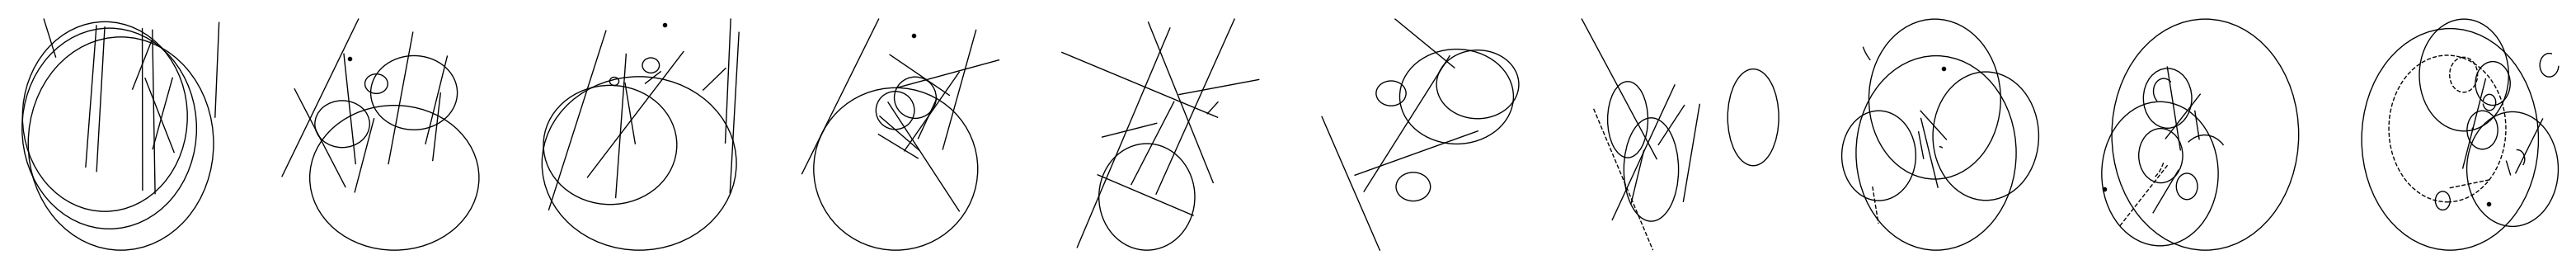

Training Iter 11999 Iter Loss: 0.19460543990135193:   6%|▌         | 11999/200000 [39:38<10:10:23,  5.13it/s] 

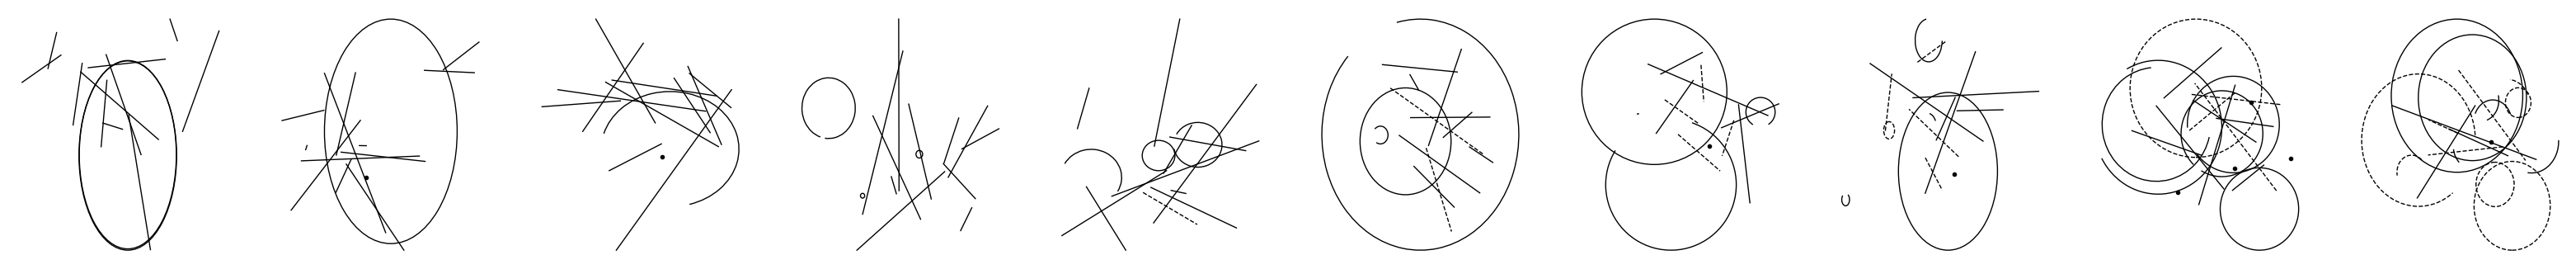

Training Iter 19999 Iter Loss: 0.5625267028808594:  10%|▉         | 19999/200000 [1:04:39<8:39:57,  5.77it/s]  

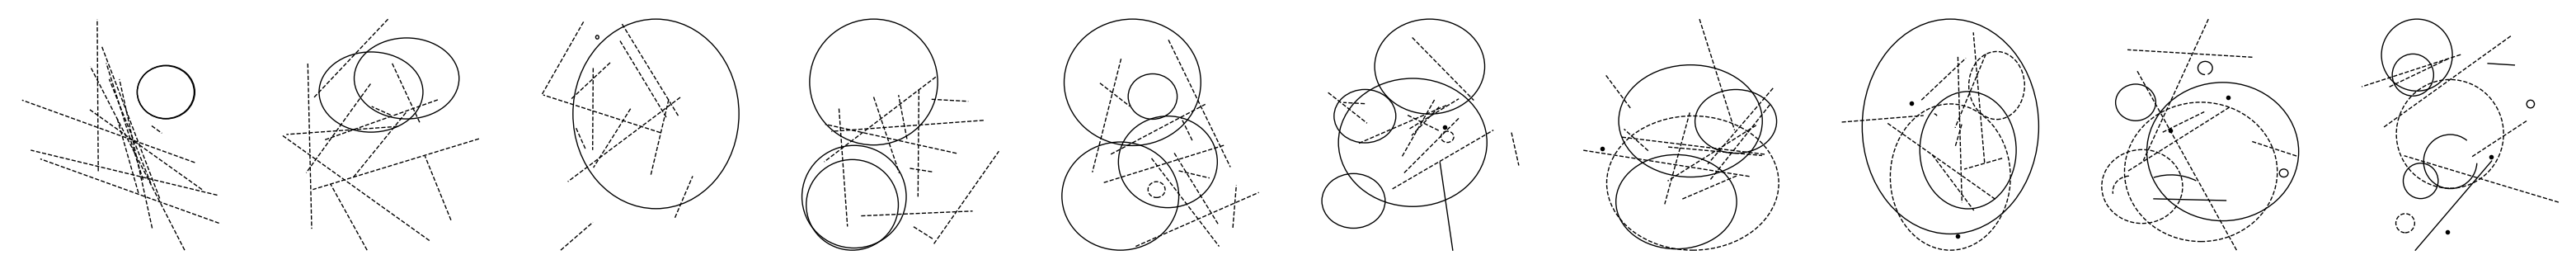

Training Iter 27999 Iter Loss: 0.23861686885356903:  14%|█▍        | 27999/200000 [1:29:41<8:32:28,  5.59it/s]  

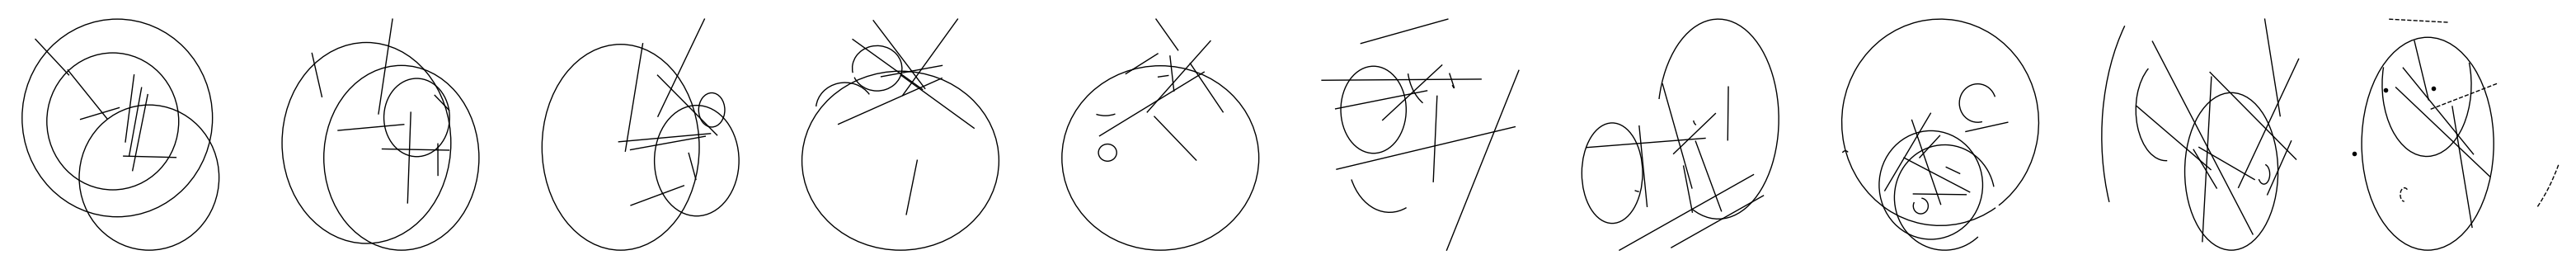

Training Iter 35999 Iter Loss: 0.5154280662536621:  18%|█▊        | 35999/200000 [1:54:47<8:10:01,  5.58it/s]   

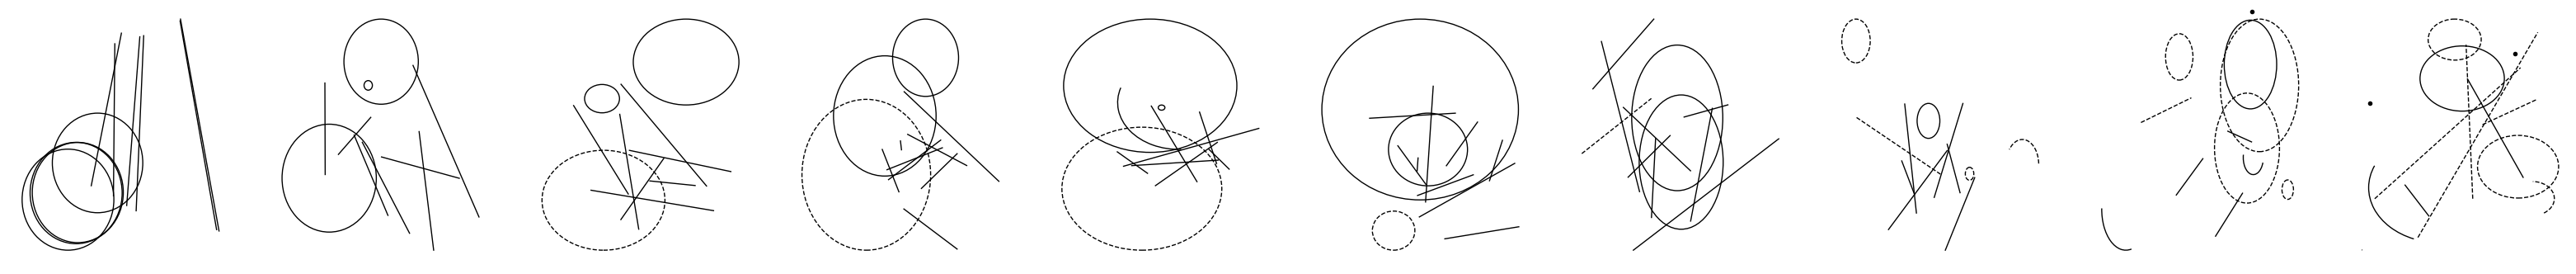

Training Iter 43999 Iter Loss: 0.7592405676841736:  22%|██▏       | 43999/200000 [2:19:59<9:21:46,  4.63it/s]   

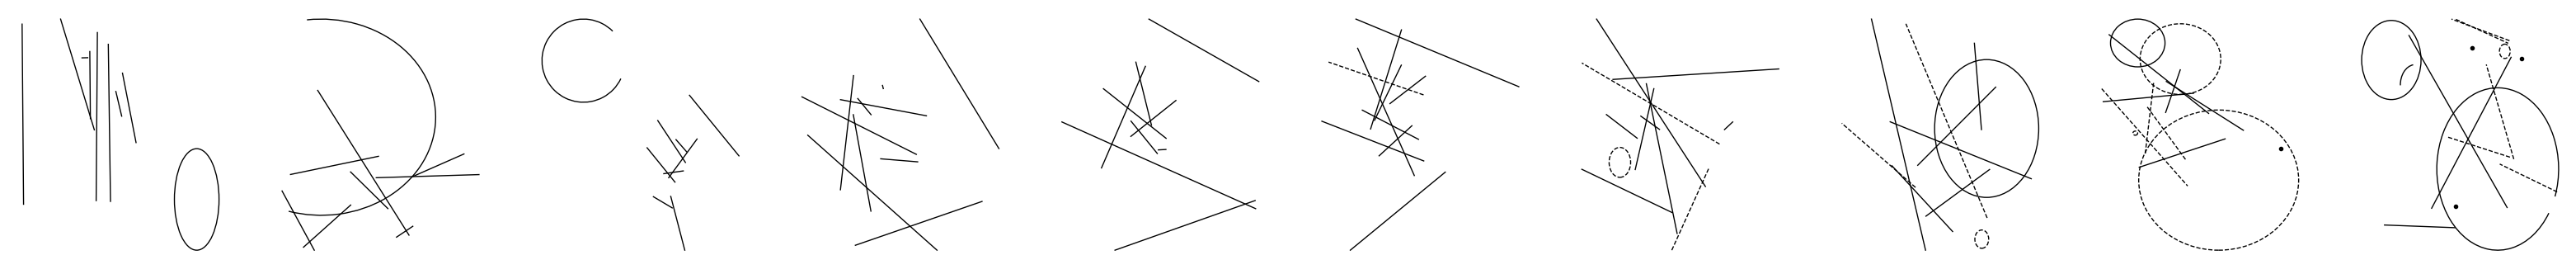

Training Iter 51999 Iter Loss: 0.40190625190734863:  26%|██▌       | 51999/200000 [2:45:07<7:32:56,  5.45it/s]  

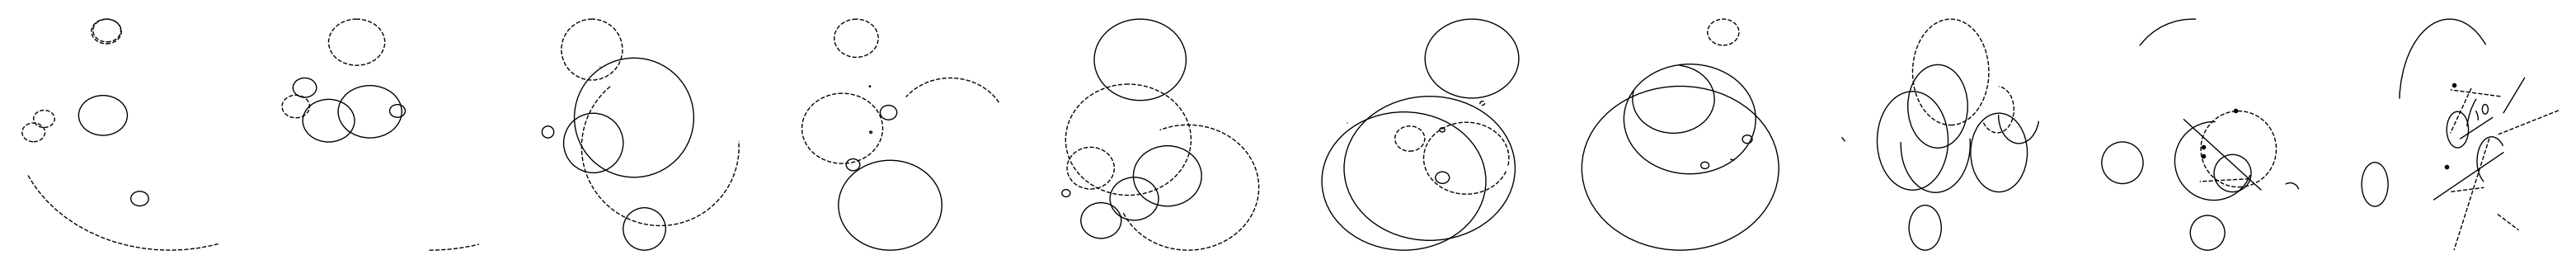

Training Iter 59999 Iter Loss: 0.05138314515352249:  30%|██▉       | 59999/200000 [3:10:26<7:13:11,  5.39it/s]  

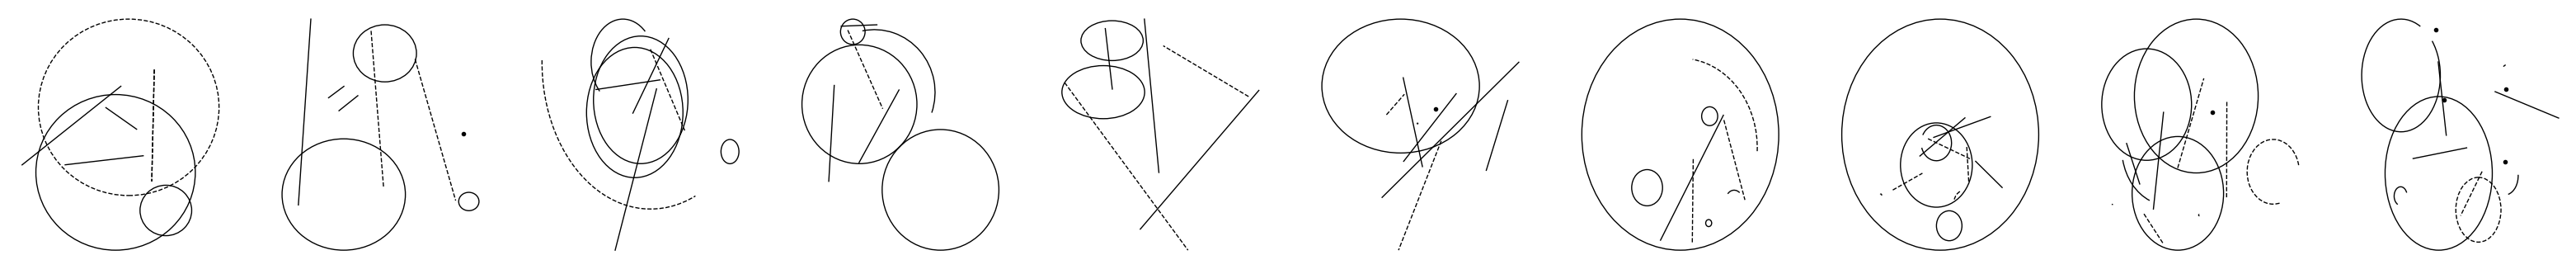

Training Iter 67999 Iter Loss: 0.744987428188324:  34%|███▍      | 67999/200000 [3:35:47<6:44:11,  5.44it/s]    

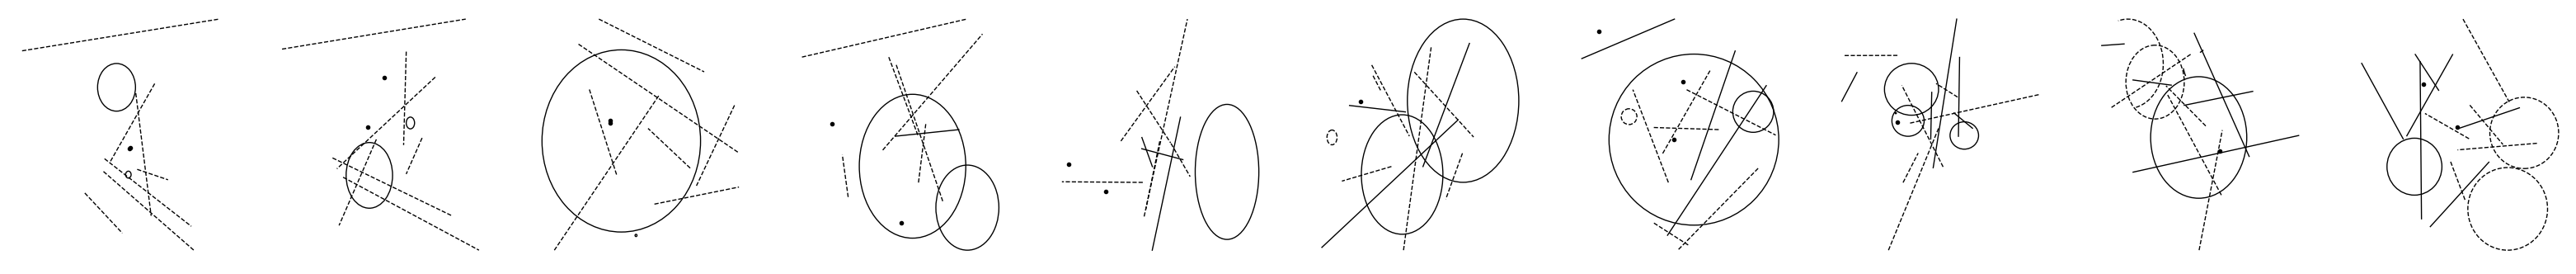

Training Iter 75999 Iter Loss: 0.25518378615379333:  38%|███▊      | 75999/200000 [4:01:01<6:16:27,  5.49it/s]   

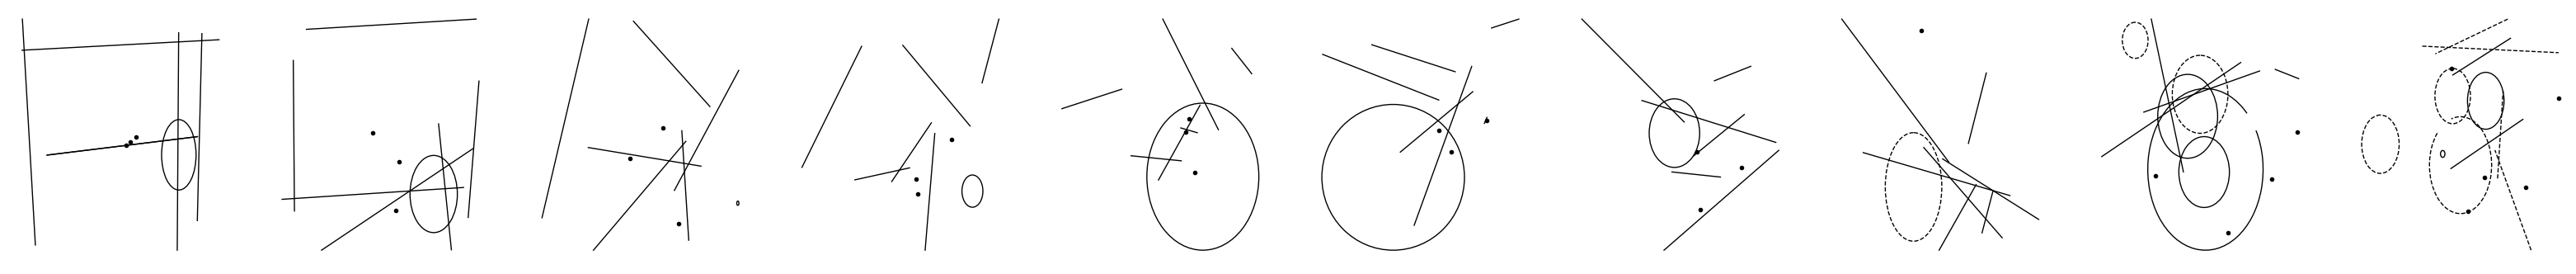

Training Iter 83999 Iter Loss: 0.2807386517524719:  42%|████▏     | 83999/200000 [4:26:27<5:47:15,  5.57it/s]   

In [18]:
model.train()
pbar = tqdm(range(iters))
for iter in pbar:
    optimizer.zero_grad()

    t = torch.randint(low = 1, high = model.max_timestep, size = (16,)).to(gpu_id)
    node_noise = torch.randn_like(nodes).to(gpu_id)
    edge_noise = torch.randn_like(edges).to(gpu_id)

    temp_nodes = nodes.detach().clone()
    temp_edges = edges.detach().clone()

    temp_nodes[...,:7] = temp_nodes[...,:7].log().clip(min = log_clip)
    temp_edges = temp_edges.log().clip(min = log_clip)

    temp_nodes[...,:7] = model.sqrt_sched.sqrt_a_bar[t,None,None] * temp_nodes[...,:7] + model.sqrt_sched.sqrt_b_bar[t,None,None] * node_noise[...,:7]
    temp_nodes[...,7:] = model.cos_sched.sqrt_a_bar[t,None,None] * temp_nodes[...,7:] + model.cos_sched.sqrt_b_bar[t,None,None] * node_noise[...,7:]
    temp_edges = model.sqrt_sched.sqrt_a_bar[t,None,None,None] * temp_edges + model.sqrt_sched.sqrt_b_bar[t,None,None,None] * edge_noise

    temp_nodes, temp_edges = model.normalize_probs(temp_nodes, temp_edges)

    pred_nodes, pred_edges = model(temp_nodes, temp_edges, t)

    loss = 16 * ((nodes[...,7:] - pred_nodes[...,7:]) ** 2 * params_mask).sum() / params_mask.sum()
    loss = loss + (-nodes[...,2:7] * (pred_nodes[...,2:7] - torch.logsumexp(input = pred_nodes[...,2:7], dim = -1, keepdim = True))).mean()
    loss = loss + (-nodes[...,0:2] * (pred_nodes[...,0:2] - torch.logsumexp(input = pred_nodes[...,0:2], dim = -1, keepdim = True))).mean()
    loss = loss + (-edges[...,0:4] * (pred_edges[...,0:4] - torch.logsumexp(input = pred_edges[...,0:4], dim = -1, keepdim = True))).mean()
    loss = loss + (-edges[...,4:8] * (pred_edges[...,4:8] - torch.logsumexp(input = pred_edges[...,4:8], dim = -1, keepdim = True))).mean()
    loss = loss + (-edges[...,8: ] * (pred_edges[...,8: ] - torch.logsumexp(input = pred_edges[...,8: ], dim = -1, keepdim = True))).mean()
    # loss = F.mse_loss(pred_node_noise[...,6:] * params_mask, node_noise[...,6:] * params_mask) + F.mse_loss(pred_node_noise[...,:6], node_noise[...,:6]) + 0.1 * F.mse_loss(pred_edge_noise, edge_noise)

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    pbar.set_description(f"Training Iter {iter} Iter Loss: {loss.item()}")
    if iter % 8000 == 3999:
        model.sample(1)
    

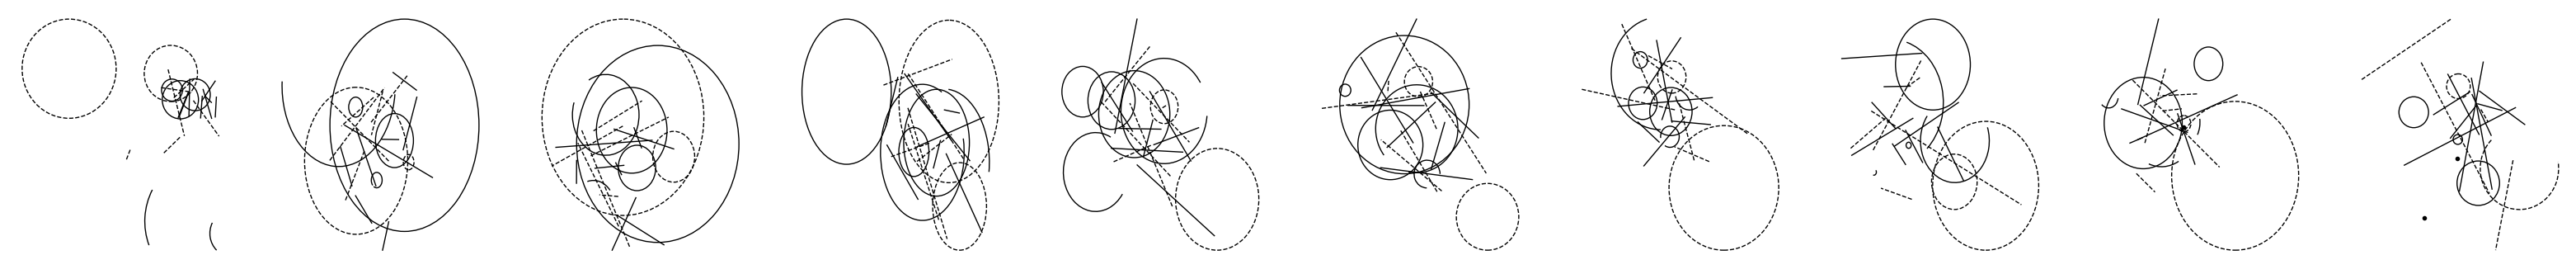

In [ ]:
model.sample(1)

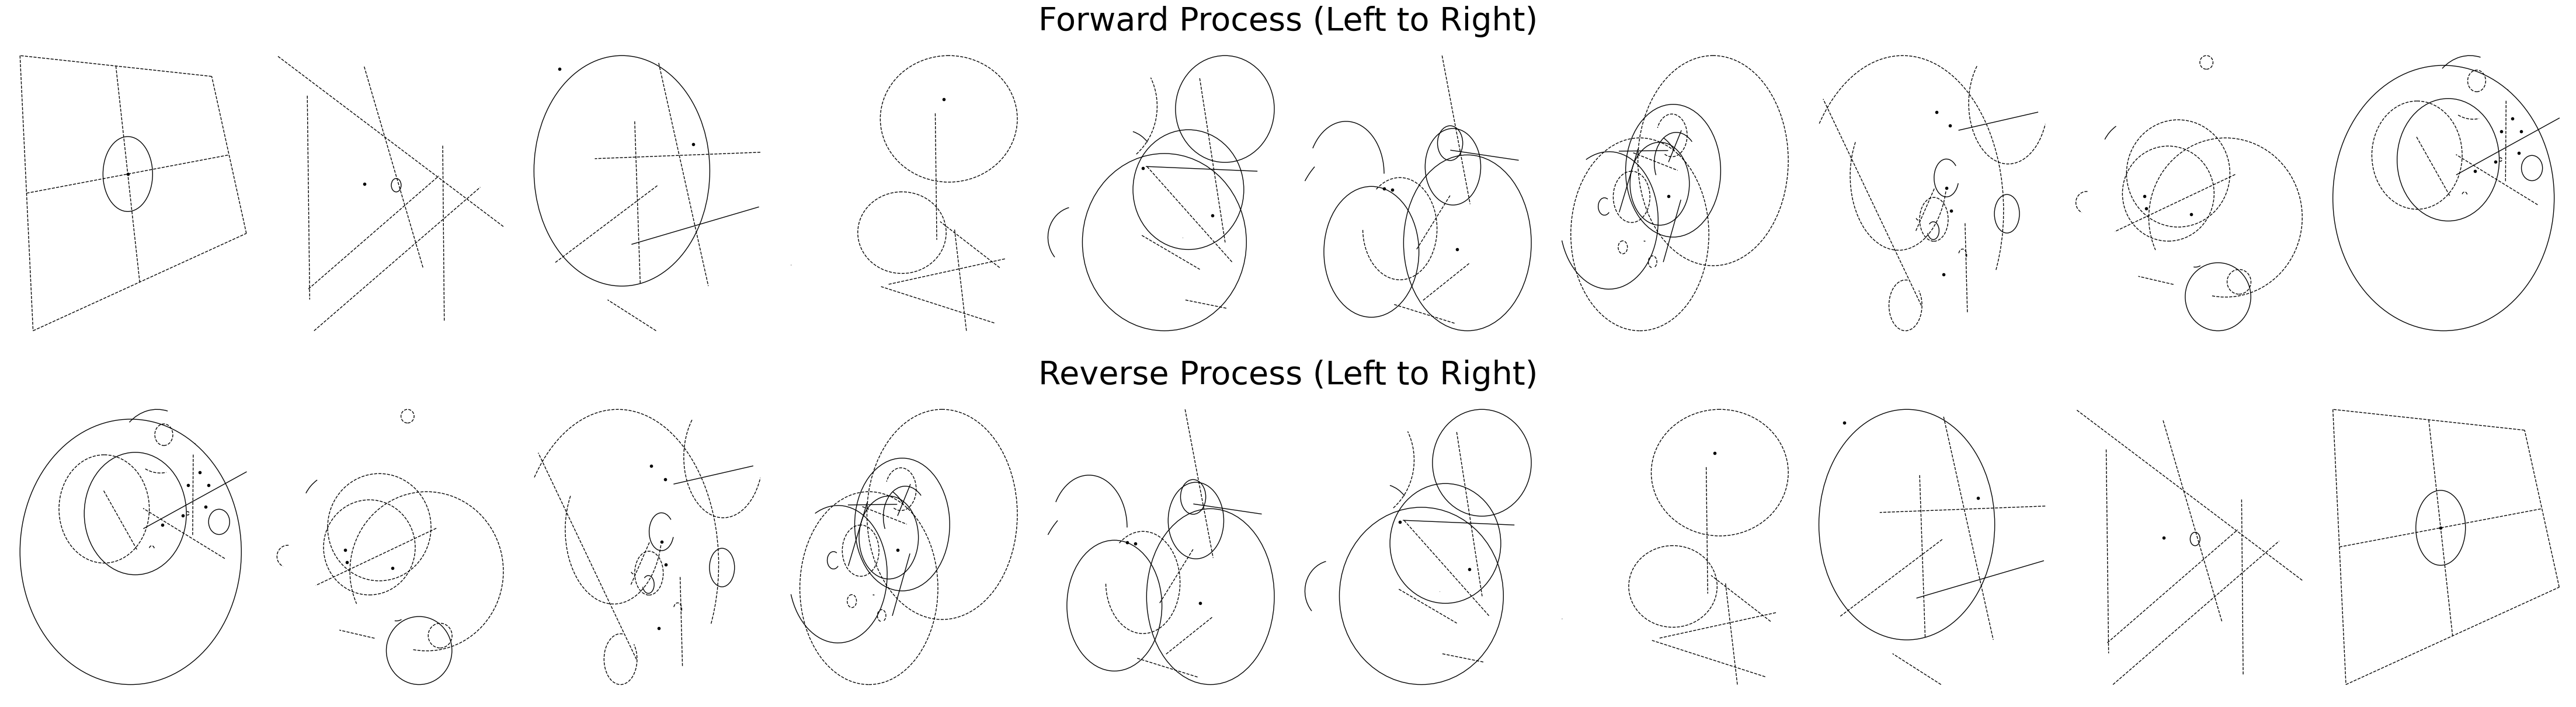

In [9]:
nodes = nodes.to(gpu_id)
edges = edges.to(gpu_id)

a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(1000 + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar = a_bar.to(gpu_id)
b_bar = 1 - a_bar

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0]).to(gpu_id)])
b = 1 - a

sqrt_a = a.sqrt()
sqrt_b = (1 - a).sqrt()
sqrt_a_bar = a_bar.sqrt()
sqrt_b_bar = (1 - a_bar).sqrt()

sqrt_post_var = torch.cat([torch.tensor([0.0]).to(gpu_id), (a_bar[:-1] / a_bar[1:] * b[1:])]).sqrt()


@torch.no_grad()
def sample(batch_size : int):
    sampled_nodes = torch.randn((batch_size, 24, 21)).to(gpu_id)
    sampled_edges = torch.randn((batch_size, 24, 24, 17)).to(gpu_id)
    sampled_nodes, sampled_edges = normalize_probs(sampled_nodes, sampled_edges)

    num_images = 10
    j = num_images - 1
    # fig, axes = plt.subplots(nrows = 2, ncols = num_images, figsize=(40, 8))
    fig = plt.figure(constrained_layout=True, figsize=(44, 12))

    subfigs = fig.subfigures(nrows=2, ncols=1)
    subfigs[0].suptitle("Forward Process (Left to Right)", size = 40)
    axsf = subfigs[0].subplots(nrows=1, ncols=10)
    subfigs[1].suptitle("Reverse Process (Left to Right)", size = 40)
    axsr = subfigs[1].subplots(nrows=1, ncols=10)

    stepsize = int(1000/num_images)

    for i in reversed(range(1, 1000)):
      pred_nodes, pred_edges = nodes, edges # self.forward(sampled_nodes, sampled_edges, torch.full(size = (batch_size,), fill_value = i).to(self.device))
      # pred_nodes, pred_edges = self.normalize_probs(pred_nodes, pred_edges)
      sampled_nodes, sampled_edges = reverse_step(sampled_nodes, sampled_edges, pred_nodes, pred_edges, i)
      if i % stepsize == 1:
        SketchDataset.render_graph(sampled_nodes[0][...,1:].cpu(), sampled_edges[0].cpu(), axsf[j])
        SketchDataset.render_graph(sampled_nodes[0][...,1:].cpu(), sampled_edges[0].cpu(), axsr[num_images - j - 1])
        j = j - 1
    
    plt.show()
    plt.close(fig)

@torch.no_grad()
def reverse_step(nodes : Tensor, edges : Tensor, pred_nodes : Tensor, pred_edges : Tensor, t : int):
    nodes[...,7:] = continuous_reverse(nodes[...,7:], pred_nodes[...,7:], t)

    nodes[...,0:2] = discrete_reverse(nodes[...,0:2], pred_nodes[...,0:2], t)
    nodes[...,2:7] = discrete_reverse(nodes[...,2:7], pred_nodes[...,2:7], t)
    edges[...,0:4] = discrete_reverse(edges[...,0:4], pred_edges[...,0:4], t)
    edges[...,4:8] = discrete_reverse(edges[...,4:8], pred_edges[...,4:8], t)
    edges[...,8:] = discrete_reverse(edges[...,8:], pred_edges[...,8:], t)

    return nodes, edges # self.continuous_reverse(nodes, pred_nodes, t), self.continuous_reverse(edges, pred_edges, t)
  
@torch.no_grad()
def discrete_reverse(probs : Tensor, pred : Tensor, t : int):
    curr_logits = probs.log().clip(-10)
    pred_logits = pred.log().clip(-10)
    # log_c = -torch.logsumexp( (curr_logits - sqrt_b_bar[t] * pred) / sqrt_a_bar[t], dim = -1, keepdim = True)

    # pred_logits = pred + log_c # Normalize logits of pred since since model predicts unnormalized log probabilities
    return torch.softmax(continuous_reverse(curr_logits, pred, t), dim = -1)

    # denoised_mean = (logits - self.softmax_scale * self.b[t] / self.sqrt_b_bar[t] * pred) / self.sqrt_a[t]

    # if t > 1:
    #   return torch.softmax(denoised_mean + self.sqrt_post_var[t] * torch.randn_like(denoised_mean), dim = -1)
    # else:
    #    return torch.softmax(denoised_mean, dim = -1)
  
@torch.no_grad()
def continuous_reverse(noised : Tensor, pred : Tensor, t : int):
    # denoised_mean = (noised - self.b[t] / self.sqrt_b_bar[t] * pred_noise) / self.sqrt_a[t]
    denoised_mean = (sqrt_a_bar[t - 1] * b[t] * pred + sqrt_a[t] * b_bar[t - 1] * noised) / b_bar[t]
    if t > 1:
      return denoised_mean + sqrt_post_var[t] * torch.randn_like(denoised_mean)
    else:
       return denoised_mean

@torch.no_grad()
def normalize_probs(nodes, edges):
    # nodes[...,0] = torch.sigmoid(input = nodes[...,0])
    nodes[...,0:2] = torch.softmax(input = nodes[...,0:2], dim = -1)
    nodes[...,2:7] = torch.softmax(input = nodes[...,2:7], dim = -1)
    edges[...,0:4] = torch.softmax(input = edges[...,0:4], dim = -1)
    edges[...,4:8] = torch.softmax(input = edges[...,4:8], dim = -1)
    edges[...,8:] = torch.softmax(input = edges[...,8:], dim = -1)
    return nodes, edges

sample(16)